In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
"""
    Global variables.
    DATA_DIR -> the directory where the files are
    DATA_FILE -> the name of the file
"""
DATA_DIR = 'F:/Python/Time Series - Airbnb/data/'
DATA_FILE = 'data_for_prediction.csv'

In [3]:
data = pd.read_csv(DATA_DIR+DATA_FILE)
display(data.head(10))

,ds,ts,ts_log,ts_log_moving_avg,ts_moving_avg,ts_log_diff,ts_moving_avg_diff,ts_log_moving_avg_diff,ts_log_ewma,ts_log_ewma_diff,trend,seasonal,resid
0,2010-07-04,1.0,0.000000,0.198042,1.285714,-0.693147,-0.285714,-0.198042,0.000000,0.000000,NaN,0.001257,NaN
1,2010-07-05,1.0,0.000000,0.099021,1.142857,0.000000,-0.142857,-0.099021,0.000000,0.000000,NaN,0.075568,NaN
2,2010-07-06,1.0,0.000000,0.099021,1.142857,0.000000,-0.142857,-0.099021,0.000000,0.000000,NaN,0.056422,NaN
3,2010-07-16,2.0,0.693147,0.594126,1.857143,0.000000,0.142857,0.099021,0.199809,0.493339,NaN,0.024812,NaN
4,2010-07-28,1.0,0.000000,0.255966,1.428571,0.000000,-0.428571,-0.255966,0.151569,-0.151569,NaN,-0.030235,NaN
5,2010-07-29,1.0,0.000000,0.255966,1.428571,0.000000,-0.428571,-0.255966,0.119670,-0.119670,NaN,-0.011014,NaN
6,2010-07-30,2.0,0.693147,0.255966,1.428571,0.693147,0.571429,0.437182,0.227801,0.465347,NaN,-0.045991,NaN
7,2010-08-28,3.0,1.098612,0.726799,2.285714,0.405465,0.714286,0.371813,0.377848,0.720764,NaN,-0.015152,NaN
8,2010-08-29,1.0,0.000000,0.726799,2.285714,-1.098612,-1.285714,-0.726799,0.317455,-0.317455,NaN,0.115458,NaN
9,2010-08-30,3.0,1.098612,0.726799,2.285714,1.098612,0.714286,0.371813,0.434630,0.663983,NaN,0.121176,NaN


In [6]:
df = data.loc[:,['ts','ds']]
df.rename(columns={'ds':'ds','ts':'y'},inplace=True)
df['ds']= pd.to_datetime(df['ds'])
df['y'] = pd.to_numeric(df['y'],errors='ignore')
display(df)

,y,ds
182,7.0,2011-07-22
183,7.0,2011-07-23
184,11.0,2011-07-24
185,9.0,2011-07-25
186,11.0,2011-07-26
187,9.0,2011-07-27
188,14.0,2011-07-28
189,5.0,2011-07-29
190,8.0,2011-07-30
191,9.0,2011-07-31


In [12]:
def do_lstm_model(df, 
                  ts, 
                  look_back, 
                  epochs, 
                  type_ = None, 
                  train_fraction = 0.67):
    
        def create_dataset(dataset, look_back=1):
            dataX, dataY = [], []
            for i in range(len(dataset)-look_back-1):
                a = dataset[i:(i+look_back), 0]
                dataX.append(a)
                dataY.append(dataset[i + look_back, 0])
            return numpy.array(dataX), numpy.array(dataY)

        numpy.random.seed(7)

        # Get dataset
        dataset = df[ts].values
        dataset = dataset.astype('float32')

        # Normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset.reshape(-1, 1))

        # Split into train and test sets
        train_size = int(len(dataset) * train_fraction)
        test_size = len(dataset) - train_size
        train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

        # Reshape into X=t and Y=t+1
        look_back = look_back
        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)

        # Reshape input to be [samples, time steps, features]
        if type_ == 'regression with time steps':
            trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
            testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
        elif type_ == 'stacked with memory between batches':
            trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
            testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
        else:
            trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
            testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

        # Create and fit the LSTM network
        batch_size = 1
        model = Sequential()

        if type_ == 'regression with time steps':
            model.add(LSTM(4, input_shape=(look_back, 1)))
        elif type_ == 'memory between batches':
            model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
        elif type_ == 'stacked with memory between batches':
            model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
            model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
        else:
            model.add(LSTM(4, input_shape=(1, look_back)))

        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        if type_ == 'memory between batches' or type_ == 'stacked with memory between batches':
            for i in range(100):
                model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
                model.reset_states()
        else:
            model.fit(trainX, 
                      trainY, 
                      epochs = epochs, 
                      batch_size = 1, 
                      verbose = 2)

        # Make predictions
        if type_ == 'memory between batches' or type_ == 'stacked with memory between batches':
            trainPredict = model.predict(trainX, batch_size=batch_size)
            testPredict = model.predict(testX, batch_size=batch_size)
        else:
            trainPredict = model.predict(trainX)
            testPredict = model.predict(testX)

        # Invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform([trainY])
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform([testY])

        # Calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
        print('Train Score: %.2f RMSE' % (trainScore))
        testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
        print('Test Score: %.2f RMSE' % (testScore))

        # Shift train predictions for plotting
        trainPredictPlot = numpy.empty_like(dataset)
        trainPredictPlot[:, :] = numpy.nan
        trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

        # Shift test predictions for plotting
        testPredictPlot = numpy.empty_like(dataset)
        testPredictPlot[:, :] = numpy.nan
        testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

        # Plot baseline and predictions
        plt.plot(scaler.inverse_transform(dataset))
        plt.plot(trainPredictPlot)
        plt.plot(testPredictPlot)
        plt.show()
        plt.close()

        return

W0916 14:20:37.623738  1400 deprecation_wrapper.py:119] From E:\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0916 14:20:37.967599  1400 deprecation_wrapper.py:119] From E:\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0916 14:20:38.061309  1400 deprecation_wrapper.py:119] From E:\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0916 14:20:38.530085  1400 deprecation_wrapper.py:119] From E:\Anaconda\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0916 14:20:38.920748  1400 deprecation.py:323] From E:\Anaconda\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_disp

Epoch 1/5
 - 41s - loss: 0.0014
Epoch 2/5
 - 10s - loss: 5.5532e-04
Epoch 3/5
 - 10s - loss: 5.4642e-04
Epoch 4/5
 - 10s - loss: 5.4961e-04
Epoch 5/5
 - 10s - loss: 5.5507e-04
Train Score: 73.34 RMSE
Test Score: 340.96 RMSE


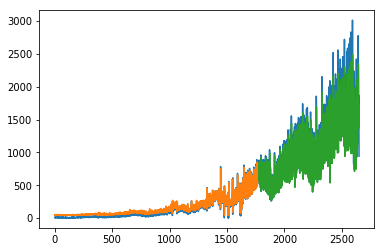

Epoch 1/5
 - 11s - loss: 0.0016
Epoch 2/5
 - 10s - loss: 5.6473e-04
Epoch 3/5
 - 10s - loss: 5.3991e-04
Epoch 4/5
 - 10s - loss: 5.1432e-04
Epoch 5/5
 - 10s - loss: 5.0564e-04
Train Score: 66.13 RMSE
Test Score: 360.96 RMSE


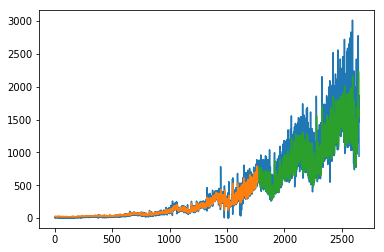

Epoch 1/5
 - 17s - loss: 9.1318e-04
Epoch 2/5
 - 16s - loss: 5.5069e-04
Epoch 3/5
 - 16s - loss: 5.3565e-04
Epoch 4/5
 - 16s - loss: 5.1745e-04
Epoch 5/5
 - 16s - loss: 5.1302e-04
Train Score: 66.94 RMSE
Test Score: 363.29 RMSE


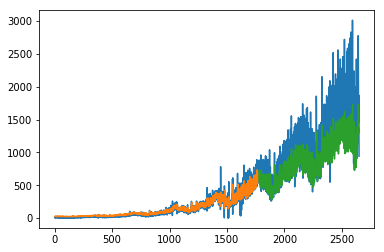

In [13]:
# LSTM Network for Regression
do_lstm_model(df = df, 
              ts = 'y', 
              look_back = 1, 
              epochs = 5)

# LSTM for Regression Using the Window Method
do_lstm_model(df = df, 
              ts = 'y', 
              look_back = 3, 
              epochs = 5)

# LSTM for Regression with Time Steps
do_lstm_model(df = df, 
              ts = 'y', 
              look_back = 3, 
              epochs = 5, 
              type_ = 'regression with time steps')